# basic

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#filtering warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# global parameters
IMG_SIZE=224
IMAGE_CHANNELS=3
batch_size = 32
epochs = 20
validation_split = 0.3

# Image Preprocessing

In [3]:
# Use the following cell to connect to google drive to access the data strored in the x_ray folder
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Please change this path to the folder that contains both the training and testing images.
os.chdir('/content/drive/My Drive/xray_dataset_covid19')

# Split the Images of the training set into those that are not infected with Corona (NI) 
# and those that are infected (I)
train_NI = os.listdir("train/NORMAL")
train_I = os.listdir("train/PNEUMONIA")

# Split the Images of the test set into Infected (I) and Not Infected (NI).
test_NI = os.listdir("test/NORMAL")
test_I = os.listdir("test/PNEUMONIA")

In [5]:
# put all path together in a dataframe

def dataframe(filenames, classes):
    return pd.DataFrame({'Filename':filenames, 'Class':[classes]*len(filenames)})

# Forming Train and Test Dataframe
train_df_NI = dataframe(train_NI, 'Normal')
train_df_I = dataframe(train_I, 'Covid')

test_df_NI = dataframe(test_NI, 'Normal')
test_df_I = dataframe(test_I, 'Covid')

#Combine both classes into a single datarame
df_train = pd.concat([train_df_NI, train_df_I], axis=0, ignore_index=True)
df_test = pd.concat([test_df_NI, test_df_I], axis=0, ignore_index=True)
df_train.head()

,Filename,Class
0,IM-0006-0001.jpeg,Normal
1,IM-0001-0001.jpeg,Normal
2,IM-0005-0001.jpeg,Normal
3,IM-0003-0001.jpeg,Normal
4,IM-0105-0001.jpeg,Normal


In [6]:
# In case there are files labeled "Thumbs.db" in the train and test dataframe
# which need to be removed as they are not images

# Examine the occurences of the "Thumbs.db" file
print("The number of .db file occurences in the training data:",len(df_train[df_train["Filename"] == "Thumbs.db"]))
print("The number of .db file occurences in the testing data:",len(df_test[df_test["Filename"] == "Thumbs.db"]))

# Remove the occurences of the "Thumbs.db"
df_train = df_train[df_train["Filename"] != "Thumbs.db"]
df_test = df_test[df_test["Filename"] != "Thumbs.db"]

# Remove all the Non-Covid-19 illnesses from the training and testing data.

# Removing the Non-Covid-19 images from the training data.
df_train.drop(df_train.index[df_train['Filename'] == "pneumocystis-pneumonia-2-PA.png"], inplace = True)
df_train.drop(df_train.index[df_train['Filename'] == "MERS-CoV-1-s2.0-S0378603X1500248X-gr4e.jpg"], inplace = True)
df_train.drop(df_train.index[df_train['Filename'] == "ARDSSevere.png"], inplace = True)
df_train.drop(df_train.index[df_train['Filename'] == "ards-secondary-to-tiger-snake-bite.png"], inplace = True)
df_train.drop(df_train.index[df_train['Filename'] == "acute-respiratory-distress-syndrome-ards-1.jpg"], inplace = True)

# Removing the Non-Covid-19 images from the testing data.
df_test.drop(df_test.index[df_test['Filename'] == "streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day3.jpg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day2.jpg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day1.jpg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day0.jpg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "streptococcus-pneumoniae-pneumonia-1.jpg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g09c-Fig9c-day27.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g09b-Fig9b-day19.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g09a-Fig9a-day17.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g07b-Fig7b-day12.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g07a-Fig7a-day5.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0.jpeg"], inplace = True)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
# Verify that are no more occurences
print("The number of .db file occurences in the training data:",len(df_train[df_train["Filename"] == "Thumbs.db"]))
print("The number of .db file occurencesin the testing data:",len(df_test[df_test["Filename"] == "Thumbs.db"]))

The number of .db file occurences in the training data: 0
The number of .db file occurences in the testing data: 0
The number of .db file occurences in the training data: 0
The number of .db file occurencesin the testing data: 0


In [7]:
def pathmaker(df,folder):
    path_list = []
    for i in df.values:
        if i[1] == 'Covid':
            path_list.append(str(folder+'/PNEUMONIA/'+i[0]))
        else:
            path_list.append(str(folder+'/NORMAL/'+i[0]))
    return path_list

# Assigning Path maker
df_train['Path'] =  pathmaker(df_train,'train')
df_test['Path'] =  pathmaker(df_test,'test')

# Visualize the df_train to ensure that the paths were appended correctly
pd.set_option('display.max_colwidth', -1)
df_train

,Filename,Class,Path
0,IM-0006-0001.jpeg,Normal,train/NORMAL/IM-0006-0001.jpeg
1,IM-0001-0001.jpeg,Normal,train/NORMAL/IM-0001-0001.jpeg
2,IM-0005-0001.jpeg,Normal,train/NORMAL/IM-0005-0001.jpeg
3,IM-0003-0001.jpeg,Normal,train/NORMAL/IM-0003-0001.jpeg
4,IM-0105-0001.jpeg,Normal,train/NORMAL/IM-0105-0001.jpeg
...,...,...,...
138,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg,Covid,train/PNEUMONIA/auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
139,kjr-21-e25-g001-l-a.jpg,Covid,train/PNEUMONIA/kjr-21-e25-g001-l-a.jpg
140,kjr-21-e24-g003-l-a.jpg,Covid,train/PNEUMONIA/kjr-21-e24-g003-l-a.jpg
141,E63574A7-4188-4C8D-8D17-9D67A18A1AFA.jpeg,Covid,train/PNEUMONIA/E63574A7-4188-4C8D-8D17-9D67A18A1AFA.jpeg


In [8]:
df_test

,Filename,Class,Path
0,NORMAL2-IM-0120-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0120-0001.jpeg
1,NORMAL2-IM-0112-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0112-0001.jpeg
2,NORMAL2-IM-0117-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0117-0001.jpeg
3,NORMAL2-IM-0072-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0072-0001.jpeg
4,NORMAL2-IM-0131-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0131-0001.jpeg
5,NORMAL2-IM-0035-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0035-0001.jpeg
6,NORMAL2-IM-0073-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0073-0001.jpeg
7,NORMAL2-IM-0139-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0139-0001.jpeg
8,NORMAL2-IM-0059-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0059-0001.jpeg
9,NORMAL2-IM-0092-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0092-0001.jpeg


Text(0.5, 1.0, 'COVID-19')

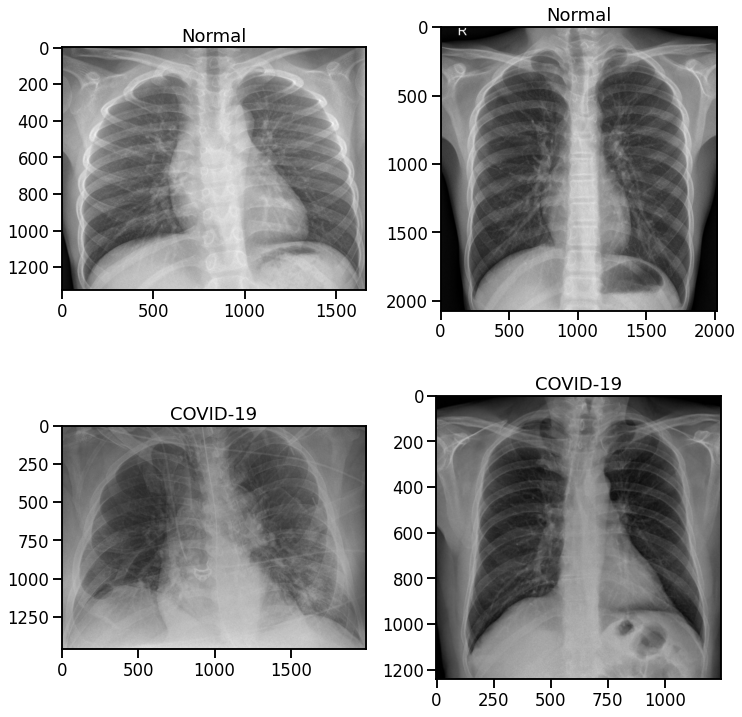

In [9]:
# Plotting Normal VS Covid in Grid

sns.set_context('talk')
plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=0.3)

plt.subplot(2, 2, 1)
plt.imshow(mpimg.imread(df_train[df_train['Class'] == 'Normal']['Path'].values[0]),cmap="gray")
plt.title('Normal')

plt.subplot(2, 2, 2)
plt.imshow(mpimg.imread(df_train[df_train['Class'] == 'Normal']['Path'].values[6]),cmap="gray")
plt.title('Normal')

plt.subplot(2, 2, 3)
plt.imshow(mpimg.imread(df_train[df_train['Class'] == 'Covid']['Path'].values[28]),cmap="gray")
plt.title('COVID-19')

plt.subplot(2, 2, 4)
plt.imshow(mpimg.imread(df_train[df_train['Class'] == 'Covid']['Path'].values[26]),cmap="gray")
plt.title('COVID-19')

different images have different size
also the shape is automatically recognised by the package
gray image may not be gray-scaled, some have dimension (width, height, 3)


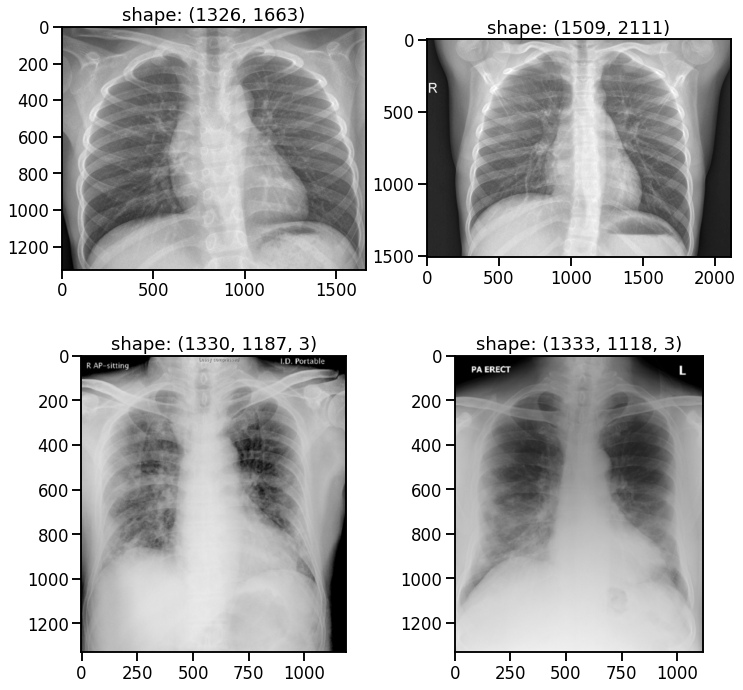

In [10]:
# problems of using raw data (before processing) for CNN

print('different images have different size')
print('also the shape is automatically recognised by the package')
print('gray image may not be gray-scaled, some have dimension (width, height, 3)')
img0 = mpimg.imread(df_train['Path'][0])
img1 = mpimg.imread(df_train['Path'][3])
img2 = mpimg.imread(df_test['Path'][22])
img3 = mpimg.imread(df_test['Path'][23])

fig, axs = plt.subplots(2, 2, figsize=(12,12))

axs[0,0].imshow(img0,cmap="gray")
axs[0,0].set_title('shape: {}'.format(img0.shape))

axs[0,1].imshow(img1,cmap="gray")
axs[0,1].set_title('shape: {}'.format(img1.shape))

axs[1,0].imshow(img2,cmap="gray")
axs[1,0].set_title('shape: {}'.format(img2.shape))

axs[1,1].imshow(img3,cmap="gray")
axs[1,1].set_title('shape: {}'.format(img3.shape))

plt.show()

In [11]:
# Pre-processing
# 1. resize all images
# 2. convert all images to have the same dimension (width, height, 3) as 'RGB' images
# note that images in keras are represented in 'RGB' color sequence

def image_preprocessor(path, desired_size=IMG_SIZE):
    im = Image.open(path).convert('RGB')
    im = im.resize((desired_size,desired_size), Image.LANCZOS)
    return im

# training set
x_train = np.empty((len(df_train), IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)

for i, path in enumerate(tqdm(df_train['Path'])):
    x_train[i,:,:,:] = image_preprocessor(path)
    
# testing set
x_test = np.empty((len(df_test), IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)

for i, path in enumerate(tqdm(df_test['Path'])):
    x_test[i,:,:,:] = image_preprocessor(path)
    
x_train = x_train/255.0
x_test = x_test/255.0

100%|██████████| 24/24 [00:07<00:00,  3.20it/s]


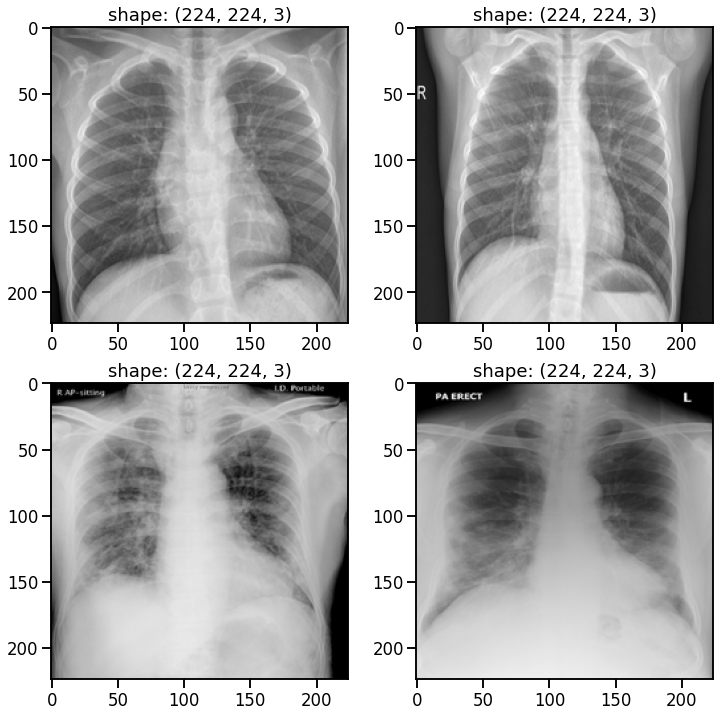

In [12]:
# some images after processing
# comparing with former examples

fig, axs = plt.subplots(2, 2, figsize=(12,12))

axs[0,0].imshow(x_train[0])
axs[0,0].set_title('shape: {}'.format(x_train[0].shape))

axs[0,1].imshow(x_train[3])
axs[0,1].set_title('shape: {}'.format(x_train[3].shape))

axs[1,0].imshow(x_test[22])
axs[1,0].set_title('shape: {}'.format(x_test[22].shape))

axs[1,1].imshow(x_test[23])
axs[1,1].set_title('shape: {}'.format(x_test[23].shape))

plt.show()

In [0]:
# Convert the "Class" collumn of the df_train and df_test dataframes into a binary variable
# with 0 indicting Normal and 1 indicating COVID

df_train['Class'] = df_train['Class'].replace(['Covid','Normal'], [1,0])
df_test['Class'] = df_test['Class'].replace(['Covid','Normal'], [1,0])

#defining output layer's output

y_train = to_categorical(df_train['Class'], num_classes=2)
y_test = to_categorical(df_test['Class'], num_classes=2)

In [0]:
# Data Augmentation

datagen = image.ImageDataGenerator(
    #rescale=1./255,
    vertical_flip = False,
    shear_range = 0,
    zoom_range = 0,
        
    horizontal_flip = True,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest',
    
    validation_split=validation_split)    
    
datagen.fit(x_train, augment=True)
generator_train = datagen.flow(x_train, y_train, subset='training', shuffle=True, batch_size=batch_size)
generator_valid = datagen.flow(x_train, y_train, subset='validation', shuffle=True, batch_size=batch_size)

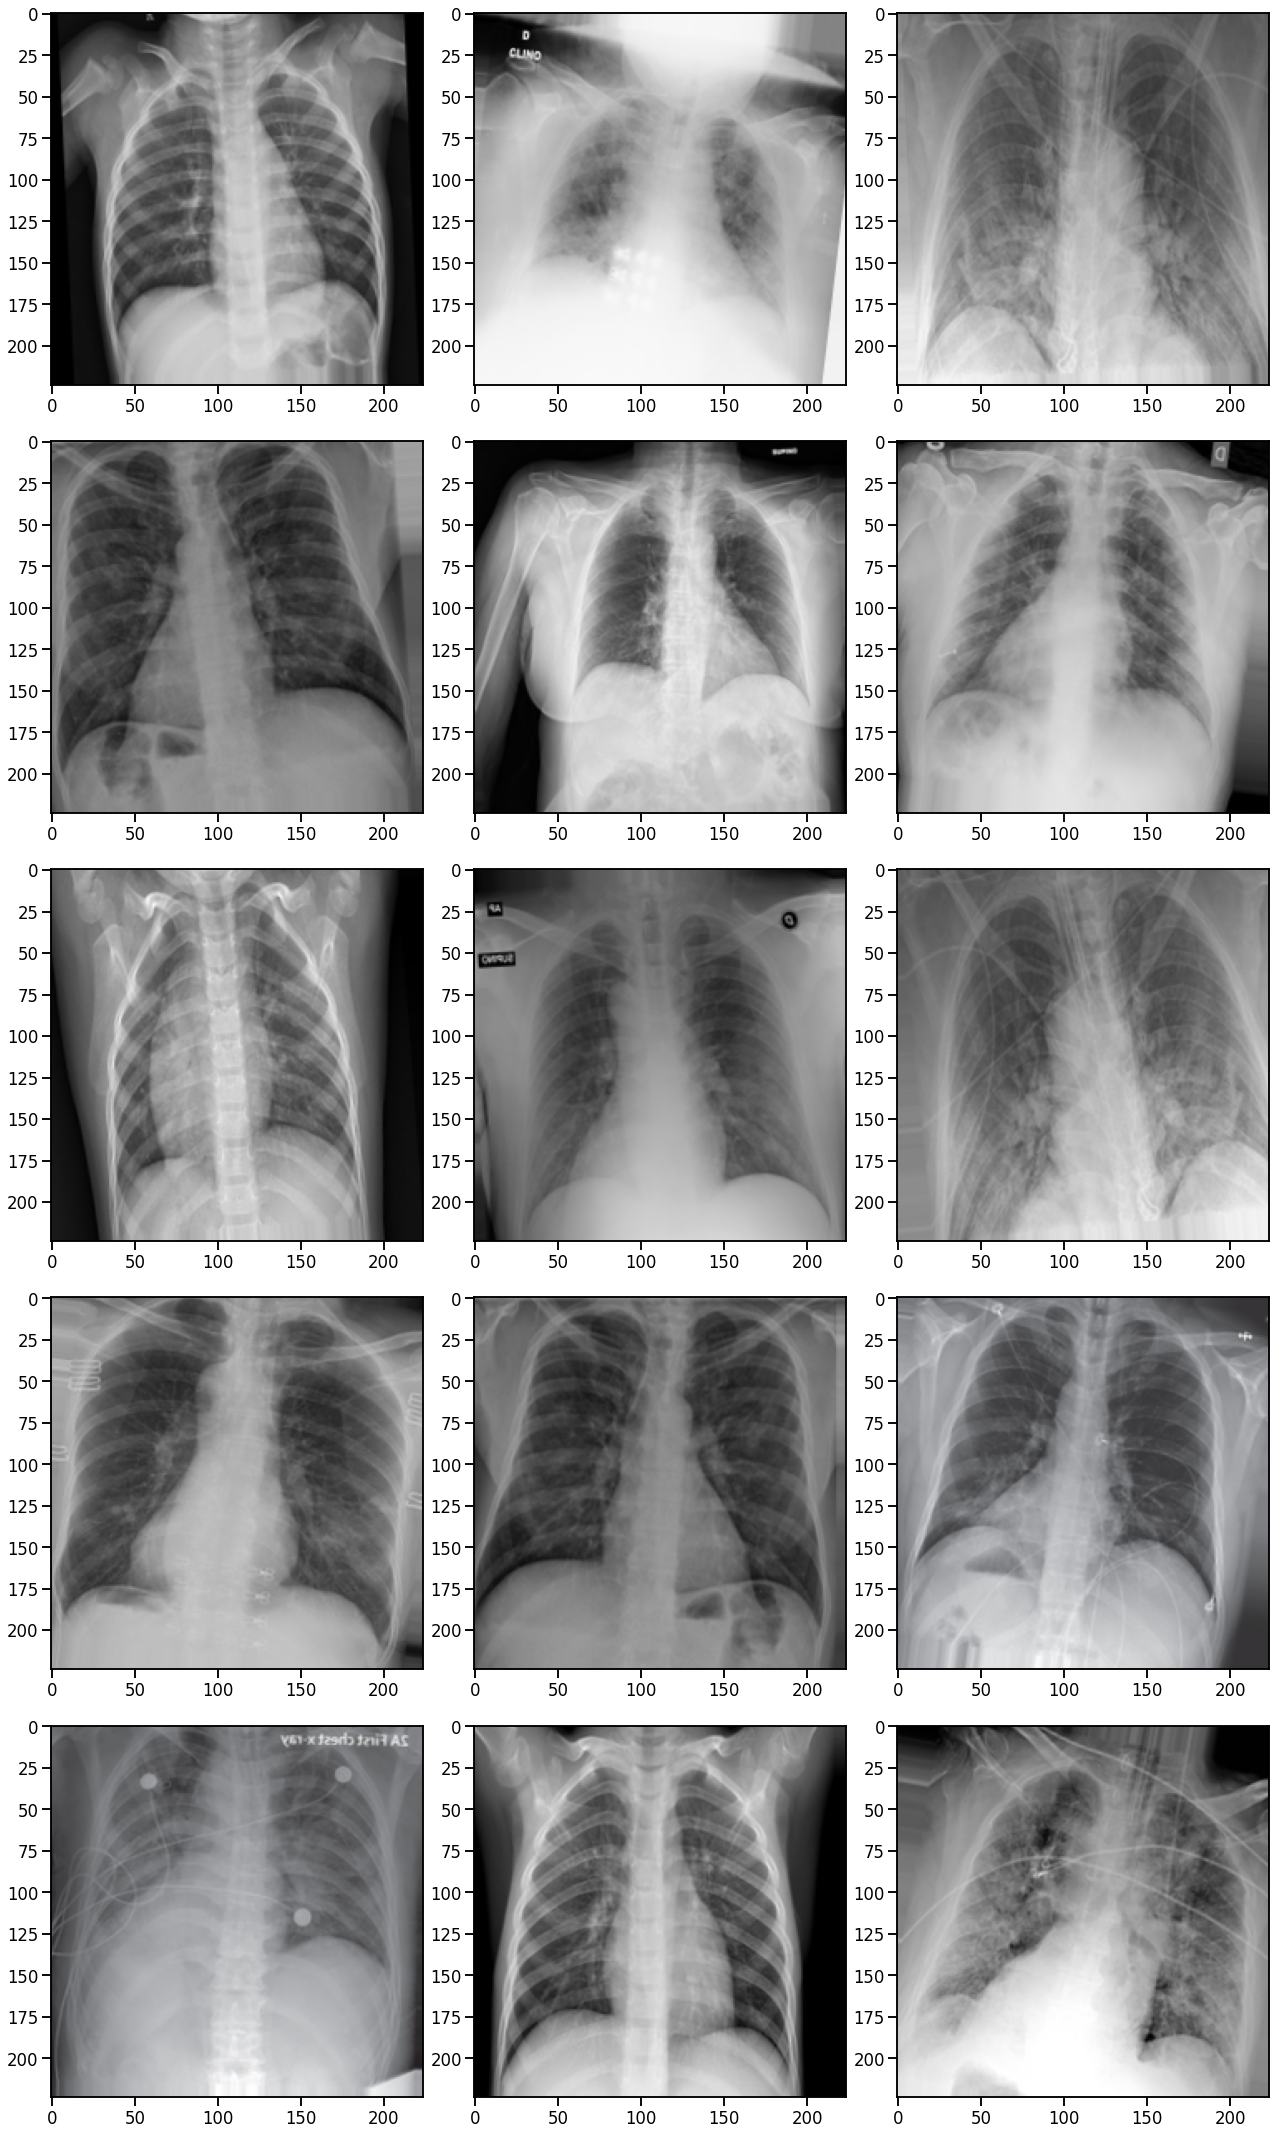

In [15]:
# visualize the data

plt.figure(figsize=(18, 30))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in generator_train:
        image = X_batch[0]
        plt.imshow(image)
        break

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Category Count')

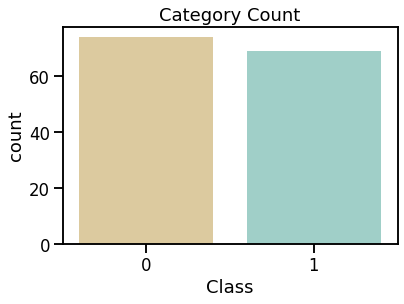

In [16]:
# additional remark: Category count Plot
sns.countplot(df_train['Class'], palette='BrBG')
plt.title('Category Count')

# Building the CNN (fit on original data)

In [0]:
model = Sequential()

#Normalization & Input
model.add(BatchNormalization(input_shape=(IMG_SIZE, IMG_SIZE, 3)))

#CNN
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))

#Max Pooling
model.add(MaxPool2D(pool_size=(2,2)))

#Dropout
model.add(Dropout(0.25))

#Flattening I/P
model.add(Flatten())

#Dense layer
model.add(Dense(128, activation='relu'))

#Dropout
model.add(Dropout(0.1))

#Output Layer with sigmoid
model.add(Dense(2, activation='sigmoid'))

#Adam as optimizer, Accuracy as evaluation metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
# overview of deep neural network
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               51380352  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [0]:
# Saving best model while monitoring accuracy
model_chkpt = ModelCheckpoint('C:/Users/WONG/Desktop/Python/STAT Big data/project/record/best_mod.h5',
                              save_best_only=True, monitor='accuracy')

# early stopping for preventing overfitting
early_stopping = EarlyStopping(monitor='loss', restore_best_weights=False, patience=5)

In [20]:
# Model fitting and tracking historical accuracy / error score
history = model.fit(x_train, y_train, 
          validation_split=validation_split, 
          epochs=epochs, batch_size=batch_size, shuffle=True, 
          callbacks=[model_chkpt, early_stopping]
         )

Epoch 1/20
4/4 [==============================] - 5s 1s/step - loss: 23.5508 - accuracy: 0.7400 - val_loss: 4.2712e-05 - val_accuracy: 1.0000
Epoch 2/20
4/4 [==============================] - 8s 2s/step - loss: 1.1277 - accuracy: 0.9200 - val_loss: 0.1719 - val_accuracy: 0.9535
Epoch 3/20
4/4 [==============================] - 5s 1s/step - loss: 0.4783 - accuracy: 0.9600 - val_loss: 1.4067 - val_accuracy: 0.8372
Epoch 4/20
4/4 [==============================] - 5s 1s/step - loss: 0.2999 - accuracy: 0.9600 - val_loss: 0.7072 - val_accuracy: 0.9070
Epoch 5/20
4/4 [==============================] - 5s 1s/step - loss: 0.3380 - accuracy: 0.9900 - val_loss: 1.4854 - val_accuracy: 0.7442
Epoch 6/20
4/4 [==============================] - 5s 1s/step - loss: 0.0543 - accuracy: 1.0000 - val_loss: 0.5632 - val_accuracy: 0.9070
Epoch 7/20
4/4 [==============================] - 5s 1s/step - loss: 0.0324 - accuracy: 1.0000 - val_loss: 0.1763 - val_accuracy: 0.9535
Epoch 8/20
4/4 [====================

Text(0, 0.5, 'Error')

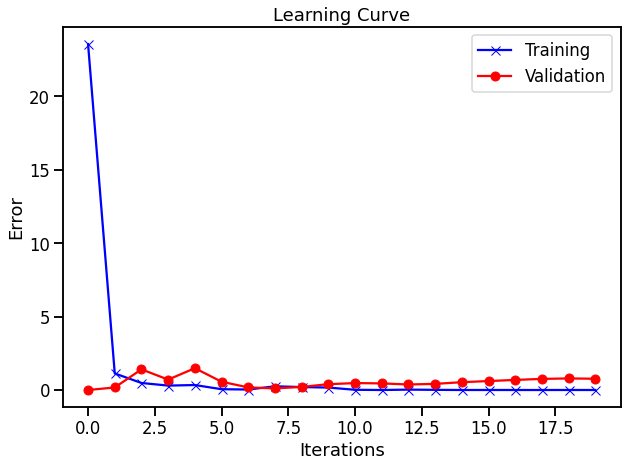

In [21]:
# plotting Learning curve over No. of Iterations
sns.set_context('talk')
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], 'b', label='Training', marker='x')
plt.plot(history.history['val_loss'], 'r', label='Validation', marker='o')
plt.legend()
plt.title('Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Error')

In [22]:
# prediction on test set
pred = model.predict(x_test, batch_size=batch_size)
# print(pred)

# converting Probabilities to labels
label = np.argmax(pred, axis=1)
label

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1])

In [23]:
# Accuracy Score
print ('Accuracy Score : ', accuracy_score(label, df_test['Class'].values), '\n')

# precision, recall report
print ('Classification Report :\n\n' ,classification_report(label, df_test['Class'].values))

Accuracy Score :  0.9166666666666666 

Classification Report :

               precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      0.67      0.80         6

    accuracy                           0.92        24
   macro avg       0.95      0.83      0.87        24
weighted avg       0.92      0.92      0.91        24



Text(0.5, 1.0, 'Confusion Matrix')

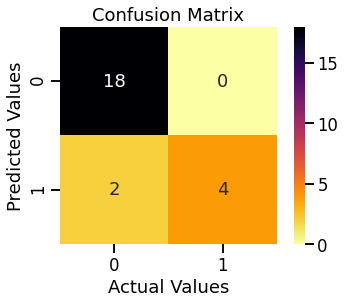

In [24]:
# plotting confusion matrix
sns.heatmap(confusion_matrix(label, df_test['Class'].values), annot=True, cmap='inferno_r', square=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix')

# Building the CNN (fit on augmented data)

In [0]:
model = Sequential()

#Normalization & Input
model.add(BatchNormalization(input_shape=(IMG_SIZE, IMG_SIZE, 3)))

#CNN
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))

#Max Pooling
model.add(MaxPool2D(pool_size=(2,2)))

#Dropout
model.add(Dropout(0.25))

#Flattening I/P
model.add(Flatten())

#Dense layer
model.add(Dense(128, activation='relu'))

#Dropout
model.add(Dropout(0.1))

#Output Layer with sigmoid
model.add(Dense(2, activation='sigmoid'))

#Adam as optimizer, Accuracy as evaluation metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
# Saving best model while monitoring accuracy
model_chkpt = ModelCheckpoint('C:/Users/WONG/Desktop/Python/STAT Big data/project/record/best_mod.h5',
                              save_best_only=True, monitor='accuracy')

# early stopping for preventing overfitting
early_stopping = EarlyStopping(monitor='loss', restore_best_weights=False, patience=5)

In [27]:
history = model.fit_generator(generator_train,
                              steps_per_epoch=len(x_train)*2/batch_size,
                              validation_data=generator_valid,
                              validation_steps=generator_valid.n//generator_valid.batch_size,
                              epochs=epochs,
                              callbacks=[model_chkpt, early_stopping],
                              verbose=False)

pd1 = pd.DataFrame(history.history)

Instructions for updating:
Please use Model.fit, which supports generators.


In [28]:
# Model fitting and tracking historical accuracy / error score
pd1 = pd.DataFrame(history.history)

for i in range(1,5):
  
  model = Sequential()

  #Normalization & Input
  model.add(BatchNormalization(input_shape=(IMG_SIZE, IMG_SIZE, 3)))

  #CNN
  model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))

  #Max Pooling
  model.add(MaxPool2D(pool_size=(2,2)))

  #Dropout
  model.add(Dropout(0.25))

  #Flattening I/P
  model.add(Flatten())

  #Dense layer
  model.add(Dense(128, activation='relu'))

  #Dropout
  model.add(Dropout(0.1))

  #Output Layer with sigmoid 
  model.add(Dense(2, activation='sigmoid'))

  #Adam as optimizer, Accuracy as evaluation metrics
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  
  history = model.fit_generator(generator_train,
                              steps_per_epoch=len(x_train)*2/batch_size,
                              validation_data=generator_valid,
                              validation_steps=generator_valid.n//generator_valid.batch_size,
                              epochs=epochs,
                              callbacks=[model_chkpt, early_stopping],
                              verbose=False)
  pd1 = pd1+pd.DataFrame(history.history)

pd1.head()

,loss,accuracy,val_loss,val_accuracy
0,55.549468,3.948904,84.408559,1.78125
1,13.193945,4.435897,71.084365,0.25000
2,4.772709,4.628205,20.386579,2.06250
3,3.168619,4.688220,23.863760,1.65625
4,2.218014,4.704571,15.190377,1.15625


Text(0, 0.5, 'Error')

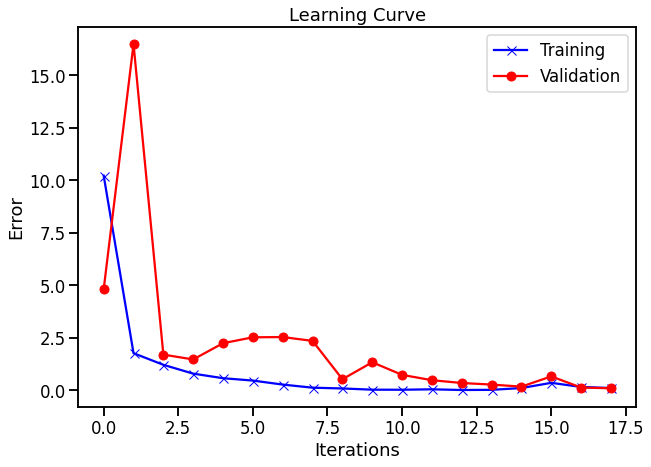

In [29]:
# plotting Learning curve over No. of Iterations
sns.set_context('talk')
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], 'b', label='Training', marker='x')
plt.plot(history.history['val_loss'], 'r', label='Validation', marker='o')
plt.legend()
plt.title('Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Error')

In [30]:
# prediction on test set
pred = model.predict(x_test, batch_size=32)
# print(pred)

# converting Probabilities to labels
label = np.argmax(pred, axis=1)
label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1])

In [31]:
# Accuracy Score
print ('Accuracy Score : ', accuracy_score(label, df_test['Class'].values), '\n')

# precision, recall report
print ('Classification Report :\n\n' ,classification_report(label, df_test['Class'].values))

Accuracy Score :  1.0 

Classification Report :

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00         4

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



Text(0.5, 1.0, 'Confusion Matrix')

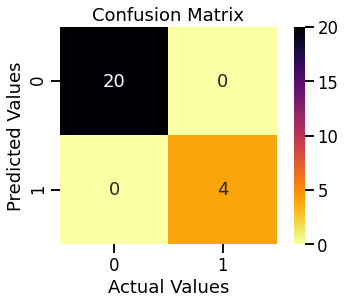

In [32]:
# plotting confusion matrix
sns.heatmap(confusion_matrix(label, df_test['Class'].values), annot=True, cmap='inferno_r', square=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix')